<a href="https://colab.research.google.com/github/ArunKoundinya/DeepLearning/blob/main/posts/deep-learning-project-msis/AmazonReviews_Part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Reviews Sentiment Analysis - Part 4

The main purpose of this file is to check why we cannot do One-Hot encoding for the text for the project.

Also, why Word-Embeddings and better neural architecture might be a better alternative approach.

## Table of Contents
- [1 - Packages](#1)
- [2 - Loading the Dataset](#2)
- [3 - Feed Forward NN with One-Hot](#3)
- [4 - Feed Forward NN with Embedding Layer](#4)

<a name='1'></a>
## 1 - Loading the Packages

In [ ]:
!pip install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.4 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16673 sha256=2f73b8745e52212f7841bdc9db50ce03da0fad4e5495b61ef28f822d09907b2b
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform


from sklearn.metrics import accuracy_score, classification_report

from pandarallel import pandarallel

<a name='1'></a>
## 2 - Loading the Data

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/')

testdata = pd.read_csv('test_data_sample_complete.csv')
traindata = pd.read_csv('train_data_sample_complete.csv')


Mounted at /content/drive


In [ ]:
# Initialize pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<a name='3'></a>
## 3 - Feed Foward NN with One-Hot

In [ ]:
train_data = traindata.sample(n=10000, random_state=42)
test_data = testdata.sample(n=1000, random_state=42)

train_data['class_index'] = train_data['class_index'].map({1:0, 2:1})
test_data['class_index'] = test_data['class_index'].map({1:0, 2:1})

train_data['review_combined_lemma'] = train_data['review_combined_lemma'].fillna('')
test_data['review_combined_lemma'] = test_data['review_combined_lemma'].fillna('')

X_train = train_data.review_combined_lemma
y_train = np.array(train_data.class_index)

X = test_data.review_combined_lemma
y = np.array(test_data.class_index)

tokenizer = Tokenizer(oov_token="<UNK>",)
tokenizer.fit_on_texts(X_train)

tokenizer.word_index['<PAD>'] = 0

X_sequences_train = tokenizer.texts_to_sequences(X_train)

X_sequences = tokenizer.texts_to_sequences(X)

X_train = pad_sequences(X_sequences_train, maxlen=100)
X = pad_sequences(X_sequences, maxlen=100)

In [ ]:
from keras.utils import to_categorical

# Assuming X_train and X are already tokenized and padded

# Convert each word into a one-hot vector
X_train_one_hot = to_categorical(X_train)
X_one_hot = to_categorical(X)

# Check the shape of the resulting one-hot vectors
print("Shape of X_train_one_hot:", X_train_one_hot.shape)
print("Shape of X_one_hot:", X_one_hot.shape)

Shape of X_train_one_hot: (10000, 100, 39128)
Shape of X_one_hot: (1000, 100, 39123)


In [ ]:
X_train_one_hot.shape

(10000, 100, 39128)

In [ ]:
model_ffnn_4 = Sequential()
model_ffnn_4.add(tf.keras.layers.Dense(units=48, activation='relu',  kernel_initializer=GlorotUniform(), input_shape=(100,39128)))
model_ffnn_4.add(tf.keras.layers.Flatten())
model_ffnn_4.add(tf.keras.layers.Dense(units=4, kernel_initializer=GlorotUniform() ,activation='relu'))
model_ffnn_4.add(tf.keras.layers.Dense(units=1,  kernel_initializer=GlorotUniform(),activation='softmax'))

In [ ]:
model_ffnn_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100, 48)           1878192   
                                                                 
 flatten_1 (Flatten)         (None, 4800)              0         
                                                                 
 dense_3 (Dense)             (None, 4)                 19204     
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1897401 (7.24 MB)
Trainable params: 1897401 (7.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_ffnn_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_ffnn_4.fit(X_train_one_hot, y_train, epochs=5, batch_size=64)

Here `V100` with `50GB` ram crashes even for 10K size dataset

<a name='4'></a>
## 4 - Feed Foward NN with Word Embeddings

In [ ]:
train_data = traindata.sample(n=10000, random_state=42)
test_data = testdata.sample(n=1000, random_state=42)

train_data['class_index'] = train_data['class_index'].map({1:0, 2:1})
test_data['class_index'] = test_data['class_index'].map({1:0, 2:1})

train_data['review_combined_lemma'] = train_data['review_combined_lemma'].fillna('')
test_data['review_combined_lemma'] = test_data['review_combined_lemma'].fillna('')

X_train = train_data.review_combined_lemma
y_train = np.array(train_data.class_index)

X = test_data.review_combined_lemma
y = np.array(test_data.class_index)

tokenizer = Tokenizer(oov_token="<UNK>",)
tokenizer.fit_on_texts(X_train)

tokenizer.word_index['<PAD>'] = 0

X_sequences_train = tokenizer.texts_to_sequences(X_train)

X_sequences = tokenizer.texts_to_sequences(X)

X_train = pad_sequences(X_sequences_train, maxlen=100)
X = pad_sequences(X_sequences, maxlen=100)

In [ ]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)

(10000, 100)
(500, 100)
(500, 100)


In [ ]:
train_data['class_index'].value_counts()

class_index
1    5046
0    4954
Name: count, dtype: int64

In [ ]:
vocab_size = len(tokenizer.word_index) + 2

In [ ]:
modelffn_embed = Sequential()
modelffn_embed.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=8, input_length=100))
modelffn_embed.add(tf.keras.layers.Flatten())
modelffn_embed.add(tf.keras.layers.Dense(32, activation='relu'))
modelffn_embed.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
modelffn_embed.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 8)            313040    
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 32)                25632     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 338705 (1.29 MB)
Trainable params: 338705 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
modelffn_embed.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
modelffn_embed.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_dev, y_dev))

loss, accuracy = modelffn_embed.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/5
157/157 [==============================] - 21s 118ms/step - loss: 0.6345 - accuracy: 0.6251 - val_loss: 0.4396 - val_accuracy: 0.8280
Epoch 2/5
157/157 [==============================] - 11s 69ms/step - loss: 0.2813 - accuracy: 0.8935 - val_loss: 0.3451 - val_accuracy: 0.8640
Epoch 3/5
157/157 [==============================] - 8s 48ms/step - loss: 0.1147 - accuracy: 0.9638 - val_loss: 0.3863 - val_accuracy: 0.8560
Epoch 4/5
157/157 [==============================] - 7s 47ms/step - loss: 0.0479 - accuracy: 0.9887 - val_loss: 0.4356 - val_accuracy: 0.8660
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 0.4828 - accuracy: 0.8520
Test Loss: 0.4828338325023651, Test Accuracy: 0.8519999980926514


In [ ]:
history_ffn_embed = modelffn_embed.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose = 0)


In [ ]:
loss, accuracy = modelffn_embed.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 2ms/step - loss: 1.1008 - accuracy: 0.8400
Test Loss: 1.1007981300354004, Test Accuracy: 0.8399999737739563


In [ ]:
pd.DataFrame(history_ffn_embed.history)

,loss,accuracy,val_loss,val_accuracy
0,0.009748,0.9992,0.520976,0.854
1,0.005276,0.9996,0.549638,0.852
2,0.003331,0.9999,0.576066,0.856
3,0.002150,0.9999,0.599153,0.848
4,0.001391,1.0000,0.644266,0.848
5,0.001092,1.0000,0.634673,0.848
6,0.000834,1.0000,0.653190,0.844
7,0.000663,1.0000,0.668371,0.844
8,0.000534,1.0000,0.681219,0.844
9,0.000432,1.0000,0.694421,0.842


In [ ]:
from plotnine import *

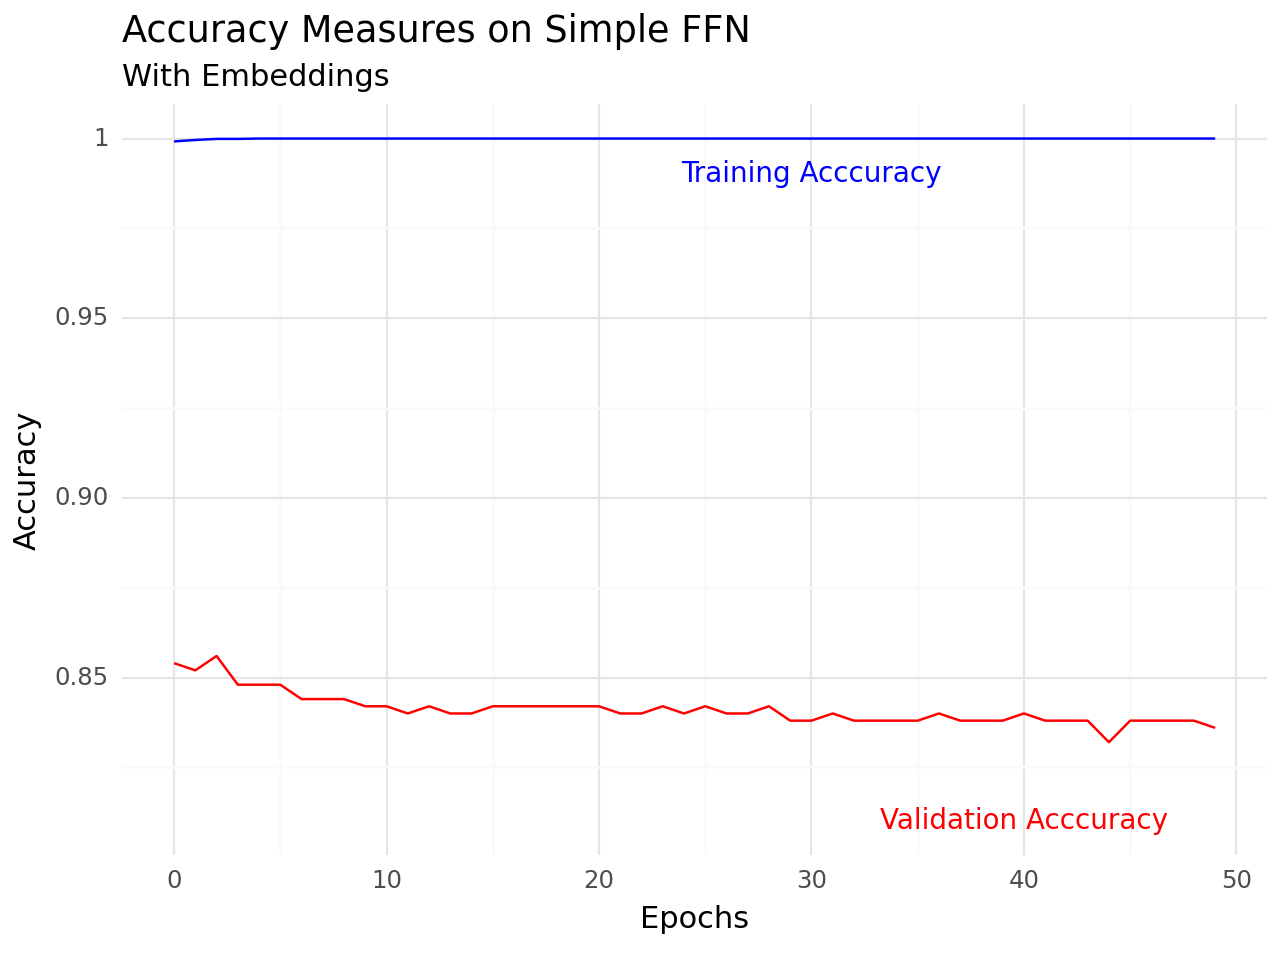

<Figure Size: (640 x 480)>

In [ ]:
( pd.DataFrame(history_ffn_embed.history) >>
 ggplot(aes(x=pd.DataFrame(history_ffn_embed.history).index, y='accuracy')) +
 geom_line(color = "blue") +
 geom_line(aes(y='val_accuracy'), color = "red") +
 theme_minimal() +
  labs(x="Epochs", y="Accuracy",
       title= "Accuracy Measures on Simple FFN",
       subtitle = "With Embeddings") +
  annotate(
      "text",
      x = 30,
      y = 0.99,
      label = "Training Acccuracy",
      color = "blue",
      size = 10
  ) +
  annotate(
      "text",
      x = 40,
      y = 0.81,
      label = "Validation Acccuracy",
      color = "red",
      size = 10
  )
 )

In [ ]:
pd.DataFrame(history_ffn_embed.history).to_csv('history_ffn_embed.csv')